After selection bicone, in this notebook we plot the OIII maps to verify if our set is good. 

 Verify the training not v2, v2 not training, training and v2


in sky unit

In [1]:
import numpy as np
from astropy.io import fits
from marvin.tools import Maps
from tqdm import tqdm
import Bicone_Classifier
import multiprocessing as mp
import copy

from scipy.fft import fft
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from marvin.utils.general.images import showImage
from marvin.tools.image import Image

from scipy import ndimage

[INFO]: No release version set. Setting default to DR17
[WARNING]: path /Users/runquanguan/sas/mangawork/manga/spectro/redux/v3_1_1/drpall-v3_1_1.fits cannot be found. Setting drpall to None. (MarvinUserWarning)
[WARNING]: path /Users/runquanguan/sas/mangawork/manga/spectro/analysis/v3_1_1/3.1.0/dapall-v3_1_1-3.1.0.fits cannot be found. Setting dapall to None. (MarvinUserWarning)
[WARNING]: Passing field metadata as keyword arguments is deprecated. Use the explicit `metadata=...` argument instead. Additional metadata: {'location': 'view_args'} (RemovedInMarshmallow4Warning)
[WARNING]: The 'missing' argument to fields is deprecated. Use 'load_default' instead. (RemovedInMarshmallow4Warning)


## Plot Image, OIII, Star_v, Gas_v, Curve, FFT. 

In [45]:
def plot_everything(data, inner = 0.6, outer = 2, step = 0.2):
    
    fig = plt.figure(figsize=(10, 7))
    
    
    '''
    HEADER_PATH = '/Users/runquanguan/Documents/dapall-v3_1_1-3.1.0.fits'
    hdul = fits.open(HEADER_PATH)
    hdu = hdul[1].data
    plateifu = hdu['PLATEIFU']
    petro_angle = hdu['NSA_ELPETRO_PHI']
    sersic_angle = hdu['NSA_SERSIC_PHI']

    dapall_index = list(plateifu).index(data)
    p_slope = np.tan(petro_angle[dapall_index])
    s_slope = np.tan(sersic_angle[dapall_index])
    '''

    maps = Maps(data, bintype='SPX', template='MILESHC-MASTARSSP')
    
    st_vel = np.flipud(maps.stellar_vel.value)
    ha_vel = np.flipud(maps.emline_gvel_ha_6564.value)
    oiii_ew = np.flipud(maps.emline_gew_oiii_5008.value)
    
    x_tik = oiii_ew.shape[0]/4
    y_tik = oiii_ew.shape[1]/4
    
    
    phi = maps.spx_ellcoo_elliptical_azimuth.value
    r_re = maps.spx_ellcoo_r_re.value
    
    for i in [oiii_ew, st_vel, ha_vel]:
        mean = np.mean(i)
        sd = np.std(i)
        for j in range(i.shape[0]):
            for k in range(i.shape[1]):
                if i[j][k] >= mean+2*sd or i[j][k]<=mean-2*sd:
                    i[j][k] = np.nan
                elif i[j][k] == 0:
                    i[j][k] = np.nan
                else:
                    pass

    axis_indicat = np.zeros(phi.shape)

    for i in range(phi.shape[0]):
        for j in range(phi.shape[1]):
            if phi[i][j] >= 88 and phi[i][j] <= 92:
                axis_indicat[i][j] = 10
            elif phi[i][j] >= 268 and phi[i][j] <= 272:
                axis_indicat[i][j] = 10
            else:
                axis_indicat[i][j] = np.nan

    axis_indicat = np.flipud(axis_indicat)
                
    rows = 2
    columns = 3
    
    # Plot the 1st image
    fig.add_subplot(rows, columns, 1)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    plt.title("Image")
    im = Image(data)
    spaxel_len = 281*2
    factor = spaxel_len / axis_indicat.shape[0]
    large_mask = ndimage.zoom(axis_indicat, factor, order=0)
    # large_mask[large_mask > 0] = 1
    mask = large_mask
    im = showImage(plateifu = data)
    masked = np.ma.masked_where(mask == 0, mask)
    plt.xlabel('arcsec')
    plt.ylabel('arcsec')
    plt.imshow(im, interpolation='none',extent=[-25,25,-25,25])
    plt.imshow(masked, cmap = 'autumn', interpolation='none', alpha=0.3,extent=[-25,25,-25,25])

    # Plot the 2nd OIII EW map
    fig.add_subplot(rows, columns, 4)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    plt.title("OIII EW Map")
    plt.xlabel('arcsec')
    plt.ylabel('arcsec')
    plt.imshow(oiii_ew, cmap = 'viridis',extent=[-1*x_tik, x_tik, -1*y_tik, y_tik])
    plt.imshow(axis_indicat, cmap = 'autumn',extent=[-1*x_tik, x_tik, -1*y_tik, y_tik], interpolation='none', alpha=0.3)

    
    # Plot the 3rd Star v
    fig.add_subplot(rows, columns, 2)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    plt.title("Stellar Velocity")
    plt.xlabel('arcsec')
    plt.ylabel('arcsec')
    plt.imshow(st_vel, cmap = 'viridis',extent=[-1*x_tik, x_tik, -1*y_tik, y_tik])
    plt.imshow(axis_indicat, cmap = 'autumn',extent=[-1*x_tik, x_tik, -1*y_tik, y_tik], interpolation='none', alpha=0.3)

    
    # Plot the 4th Gas v
    fig.add_subplot(rows, columns, 5)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    plt.title("Ha Velocity")
    plt.xlabel('arcsec')
    plt.ylabel('arcsec')
    plt.imshow(ha_vel, cmap = 'viridis',extent=[-1*x_tik, x_tik, -1*y_tik, y_tik])
    plt.imshow(axis_indicat, cmap = 'autumn', extent=[-1*x_tik, x_tik, -1*y_tik, y_tik], interpolation='none', alpha=0.3)

    
    ellip = Bicone_Classifier.ellip_gen(data)
    color = cm.viridis(np.linspace(0, 1, 8))
    
    # Plot 5rd EW dR
    fig.add_subplot(rows, columns, 3)
    fig.set_figheight(15)
    fig.set_figwidth(30)
    plt.title("OIII EW dR")
    plt.xlabel('degree')
    plt.ylabel('EW/spaxel')
    for i,c in zip(np.linspace(0.6, 2, 8), color):
        start, end = round(i,1), round(i,1)+0.3
        curve = Bicone_Classifier.ellip_ring_curve(ellip, in_r = start, out_r = end, cycle = 2)
        plt.plot(curve, c = c, alpha=0.7)


        
    # Plot 6th FTT
    fig.add_subplot(rows, columns, 6)
    fig.set_figheight(15)
    fig.set_figwidth(30)
    plt.title("Fourier Frequency")
    plt.xlabel('Hz')
    for i,c in zip(np.linspace(0.6, 2, 8), color):
        start, end = round(i,1), round(i,1)+0.3
        curve = Bicone_Classifier.ellip_ring_curve(ellip, in_r = start, out_r = end, cycle = 2)
        result = abs(fft(curve))   
        x = np.linspace(0.5, 15, 29)
        plt.plot(x, result[1:30], c = c, alpha=0.7)



    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.2)
    
    plt.savefig(data+'_vis.png')
    



[WARNING]: subprocess 47031 is still running (ResourceWarning)


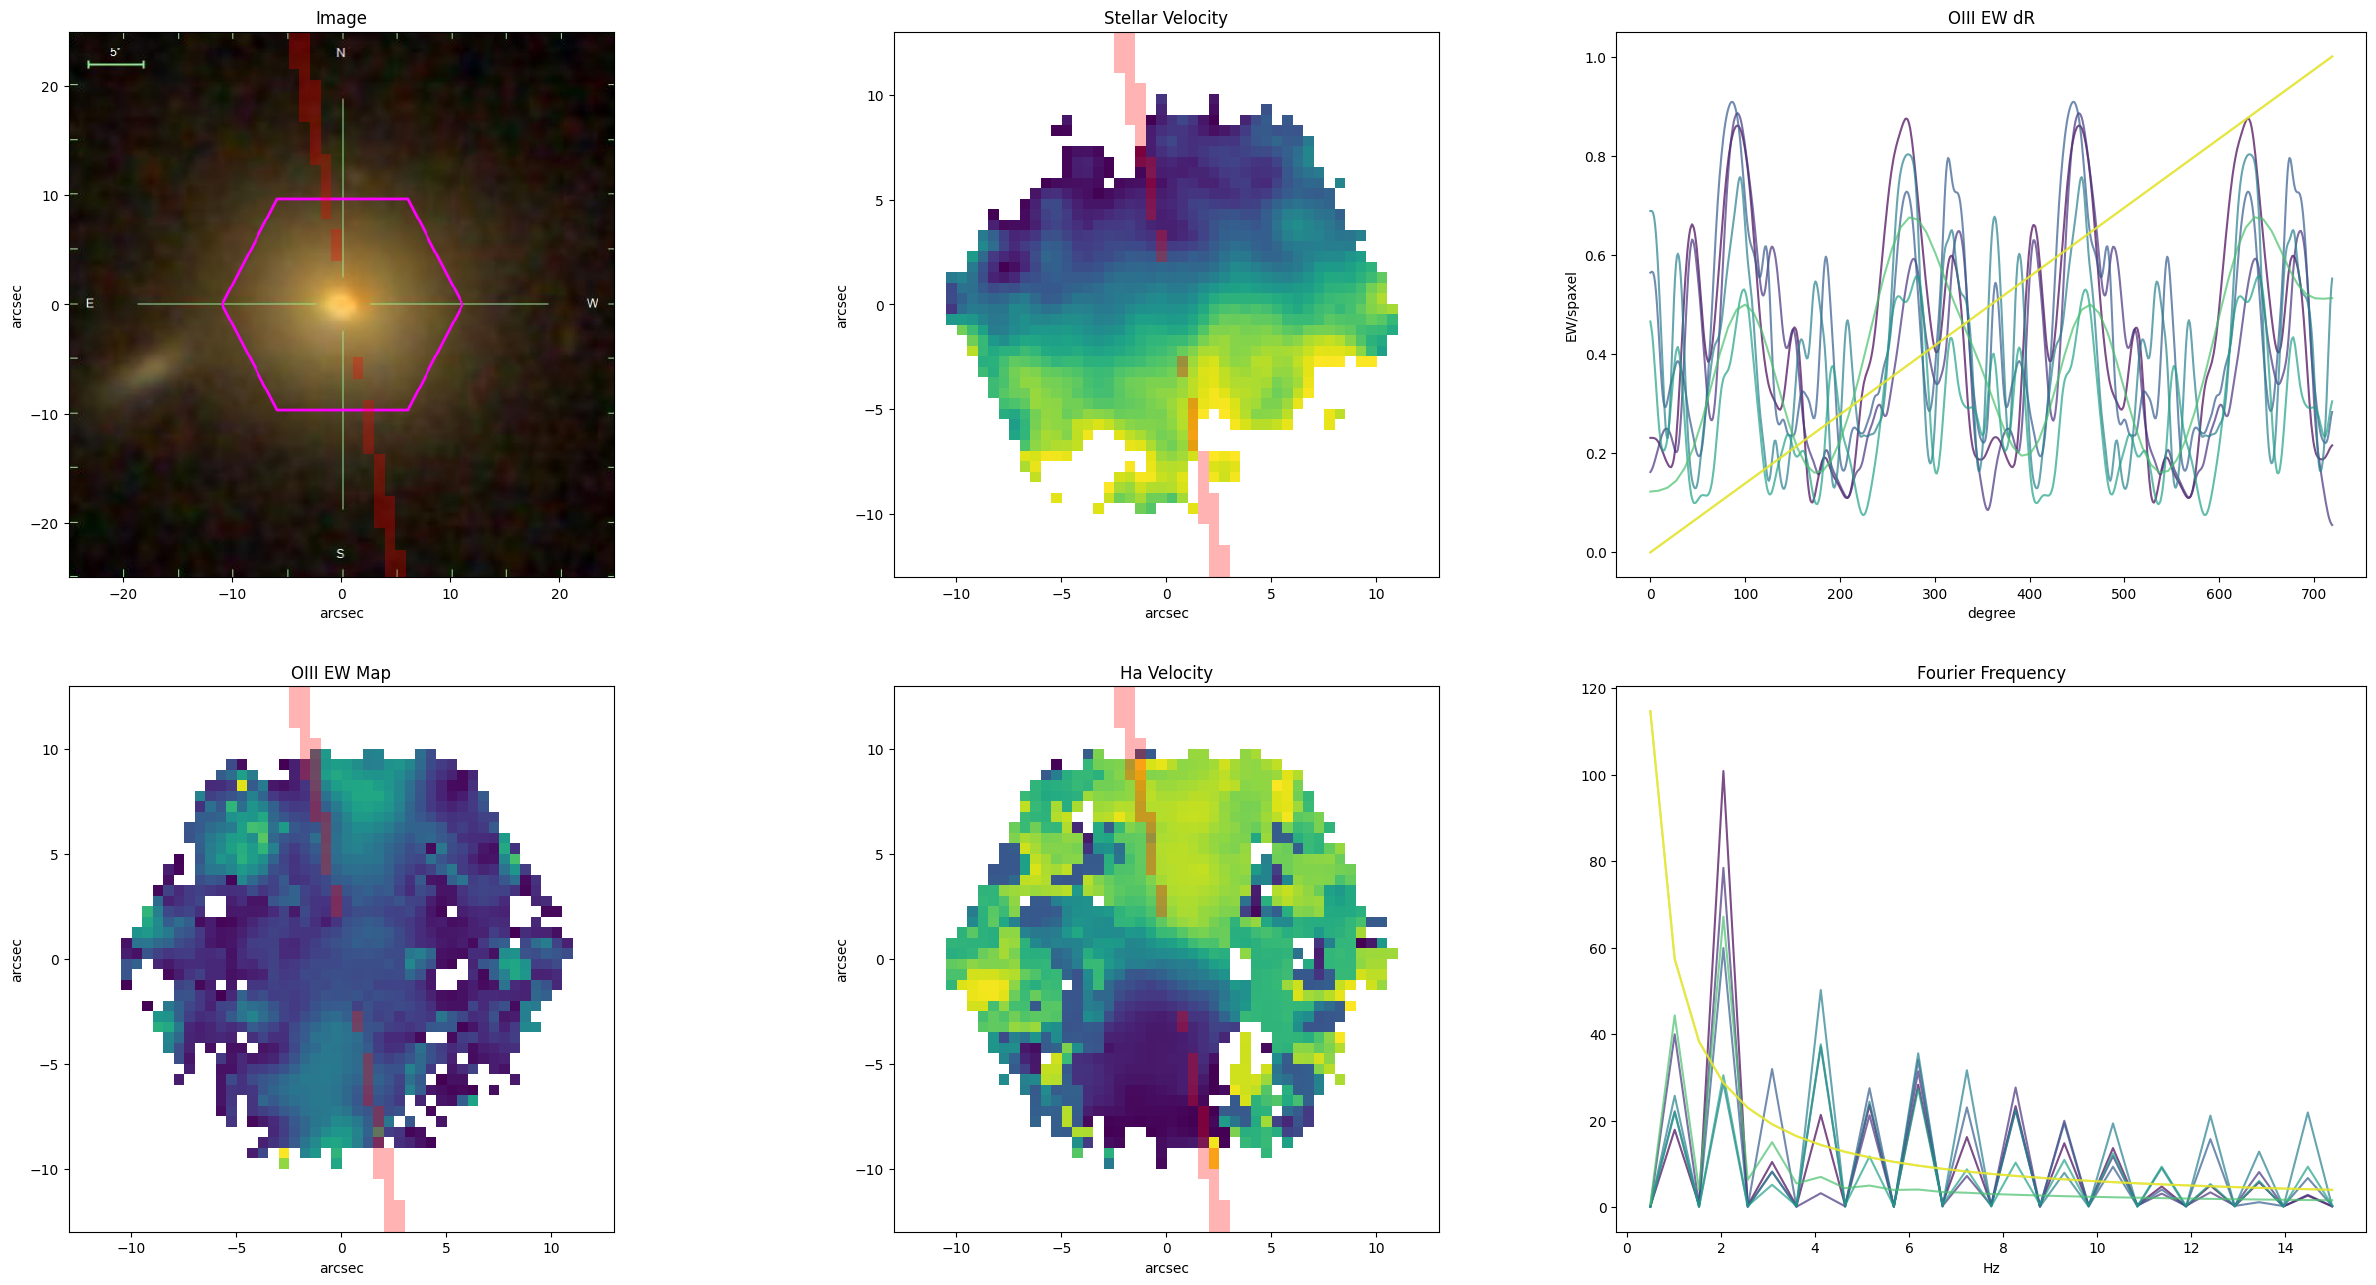

In [42]:

plot_everything(data)

In [47]:
SAMPLE_PATH = '/Users/runquanguan/Documents/sampe_not_v2.fits'
hdul_2 = fits.open(SAMPLE_PATH)
hdu_2 = hdul_2[1].data
plateifu_2 = hdu_2['plateifu']


for i in plateifu_2:
    if len(i) >= 2:
        print(i)
        plot_everything(i)
    else:
        pass






7990-1901


[WARNING]: subprocess 47184 is still running (ResourceWarning)


7990-3702


[WARNING]: subprocess 47191 is still running (ResourceWarning)


7990-9102


[WARNING]: subprocess 47197 is still running (ResourceWarning)


8132-1902


[WARNING]: subprocess 47205 is still running (ResourceWarning)


8156-6102


[WARNING]: subprocess 47210 is still running (ResourceWarning)


8253-12703


[WARNING]: subprocess 47216 is still running (ResourceWarning)


8320-1901


[WARNING]: subprocess 47222 is still running (ResourceWarning)


8439-3701


[WARNING]: subprocess 47228 is still running (ResourceWarning)


8449-1902


[WARNING]: subprocess 47236 is still running (ResourceWarning)


8462-9101


[WARNING]: subprocess 47242 is still running (ResourceWarning)


8551-1901


[WARNING]: subprocess 47251 is still running (ResourceWarning)


8562-1901


[WARNING]: subprocess 47257 is still running (ResourceWarning)


8568-1901


[WARNING]: subprocess 47265 is still running (ResourceWarning)


8588-3703


[WARNING]: subprocess 47273 is still running (ResourceWarning)


8619-9102


[WARNING]: subprocess 47281 is still running (ResourceWarning)


8716-12704


[WARNING]: subprocess 47287 is still running (ResourceWarning)


8726-1901


[WARNING]: subprocess 47294 is still running (ResourceWarning)


8950-12701


[WARNING]: subprocess 47300 is still running (ResourceWarning)


9089-3704


[WARNING]: subprocess 47306 is still running (ResourceWarning)


9091-12703


[WARNING]: subprocess 47312 is still running (ResourceWarning)


9094-12703


[WARNING]: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). (RuntimeWarning)
[WARNING]: subprocess 47320 is still running (ResourceWarning)


9485-3701


[WARNING]: subprocess 47326 is still running (ResourceWarning)


9502-12704


[WARNING]: subprocess 47332 is still running (ResourceWarning)


9503-3702


[WARNING]: subprocess 47341 is still running (ResourceWarning)


10513-1902


[WARNING]: subprocess 47346 is still running (ResourceWarning)


10519-1901


[WARNING]: subprocess 47352 is still running (ResourceWarning)


11832-1902


[WARNING]: subprocess 47359 is still running (ResourceWarning)


11833-12701


[WARNING]: subprocess 47365 is still running (ResourceWarning)


11834-9102


[WARNING]: subprocess 47371 is still running (ResourceWarning)


11968-3702


[WARNING]: subprocess 47377 is still running (ResourceWarning)


12489-12705


[WARNING]: subprocess 47384 is still running (ResourceWarning)
